## This Notebook produces the graphs used in the DMDEnKF paper for the second synthetic experiment:

## Comparing the DMDEnKF/Hankel-DMDEnKF against a DMD/Hankel-DMD Particle Filter modelling a sine wave

### First import the relevant dependencies, and set the plotting properties

In [5]:
#Import the relevant dependencies
from DMDEnKF.classes.DMDEnKF import DMDEnKF, TDMD
from DMDEnKF.classes.particle_filter import ParticleFilter
import DMDEnKF.helper_functions.simple_sin_functions as ssf
import DMDEnKF.helper_functions.particle_filter_functions as pff
import numpy as np
import matplotlib.pyplot as plt
import cmath
import seaborn as sb
import pickle
from scipy.stats import multivariate_normal
import multiprocessing as mp
import math

#Set matplotlib settings as required
%matplotlib inline
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Initialise a random seed for reproducibility
np.random.seed(0)

### Set all data generation and model parameters

In [6]:
#SET ALL PARAMETERS HERE

#Data Params
num_data = 500 -1
num_for_spin_up = 100
theta_start = np.pi/64
theta_end = np.pi/8
thetas = np.linspace(theta_start,theta_end,num_data)
low_obs_cov_const = 0.05**2
high_obs_cov_const = 0.5**2

#SELECT WHETHER USING LOW OR HIGH NOISE
obs_cov_const = high_obs_cov_const


#Model Params
#DMDEnKF/HDMDEnKF params
system_cov_const = (obs_cov_const/10)**2
eig_cov_const = 0.01**2
ensemble_size = 100

#HDMDEnKF params
hankel_dim = 50


#Distributions from multiple runs params
num_runs = 1000
num_to_keep = 400
ensemble_sizes = [5,10,20,30,40,50,100]
particle_num = 1000
min_effective_sample_ratio = 0.5

### Generate the noisy data, fit the spin-up DMD and initialise parameters for the DMD-Particle Filter

In [7]:
#Generate synthetic data
data = ssf.generate_data(thetas)
true_data = data
noise = np.expand_dims(np.random.multivariate_normal([0]*2,obs_cov_const*np.identity(2),num_data+1),2)
data = data + noise


#Fit spinup TDMD model
data = np.squeeze(data).T
f = TDMD()
f.fit(data[:,:num_for_spin_up],r=2)


#Generate particle filter prior via initial state/eigs and covariance
x_len = f.data.shape[0]
e_len = f.E.shape[0]
Y = data[:,num_for_spin_up:]
#check if the initial DMD found a complex conjugate pair or not
found_conj_pair = pff.check_conj_pairs(f)
#initial state uses the eig mod and arg from the first eig if conjugate, simply the real eigs if not
if found_conj_pair:
    x0 = np.hstack([Y[:,0],[cmath.polar(e) for e in f.E][0]])
else:
    x0 = np.hstack([Y[:,0],f.E])
P0 = np.real(np.cov(f.Y-(f.DMD_modes@np.diag(f.E)@f.inv_DMD_modes@f.X)))
P0 = np.block([[P0,np.zeros([x_len,e_len])],[np.zeros([e_len,x_len]),np.diag([eig_cov_const]*e_len)]])
prior = np.random.multivariate_normal(x0,P0,particle_num)
#set relevant matrices to be used in particle filter
observation_operator = np.hstack((np.identity(x_len),np.zeros((x_len,e_len))))
system_cov = np.diag([system_cov_const]*x_len + [eig_cov_const]*e_len)
observation_cov = obs_cov_const * np.identity(x_len)

### Fit the particle filter to the data as an example, using increased efficiency model and likelihood functions, although including the orginial, more interpretable functions for readability

In [8]:
#Perform a single particle filter iteration

#Define model and likelihood functions as required for the particle filter in an intuitive but slow manner
'''
def model(particle):
    pstate = particle[:x_len]
    peigs = particle[-e_len:]
    E = [peigs[0]*np.exp(peigs[1]*1j), peigs[0]*np.exp(-peigs[1]*1j)]
    state_pred = f.DMD_modes@np.diag(E)@f.inv_DMD_modes@pstate
    #add noise to model prediction
    advanced_particle = np.hstack([state_pred,peigs]) + np.random.multivariate_normal(np.zeros(particle.shape[0]),system_cov)
    return advanced_particle

def likelihood(particle,measurement):
    like = multivariate_normal.pdf(observation_operator@particle,mean=measurement,cov=observation_cov)
    return like

pf = ParticleFilter(prior,model,likelihood,particle_num,min_effective_sample_ratio)
pf.fit(Y.T)'''


#Use vectorised versions of model and likelihood function for faster execution
def fast_model(particles):
    #seperate states and eigs
    particles = np.array(particles)
    pstates = particles[:,:x_len]
    peigs = particles[:,-e_len:]
    #apply matrix-able DMD calc
    pstates = f.inv_DMD_modes@pstates.T
    #apply eigs, with neccassary preprocessing dependant on if they are a complex conj pair or not
    if found_conj_pair:
        Es = [np.diag([peig[0]*np.exp(peig[1]*1j), peig[0]*np.exp(-peig[1]*1j)]) for peig in peigs]
    else:
        Es = [np.diag(peig) for peig in peigs]
    pstates = np.array([E@pstate for E, pstate in zip(Es,pstates.T)])
    #apply matrix-able DMD calc
    pstates = (f.DMD_modes@pstates.T).T
    #reattach eigs
    particles = np.hstack([pstates,peigs])
    #add noise
    particles = particles + np.random.multivariate_normal(np.zeros(particles.shape[-1]),system_cov,particle_num)
    return particles

def fast_likelihood(particles,measurement):
    like = multivariate_normal.pdf((observation_operator@particles.T).T,mean=measurement,cov=observation_cov)
    return like

pf = ParticleFilter(prior,fast_model,fast_likelihood,particle_num,min_effective_sample_ratio,mode='vector')
pf.fit(Y.T)

### Run the DMD-Particle Filter over multiple data trajectories and collect the error distributions.

 - The code to do this in a synchronous way is included for completeness, however is commented out and need not be run
 
 - For convenience, due to the time all the trajectories take to filter, the DMD-particle filter's code has already been run. The resulting error distributions have been saved as pickles, and the notebook will automatically load these, and use them to generate the graphs in the rest of the notebook. If you wish to run the filter over all data trajectories yourself, simply uncomment the "Run asynchronously using multiprocessing" section of the code to generate these pickles again, and then continue with the notebook as normal

In [9]:
#Multiple runs error distributions

#Run trajectory and produce error distribution over all timesteps of the run
#this is a wrapper function for convenience to run over multiple cores using multiporcessing
def trajectory_wrapper(random_state):
    #takes in a random state, to allow for different generation of random noise for each process
    np.random.seed(random_state)
    #generate data
    data = ssf.generate_data(thetas)
    noise = np.expand_dims(np.random.multivariate_normal([0]*2,obs_cov_const*np.identity(2),500),2)
    data = data + noise
    
    #run trajectory
    traj= pff.run_pf_trajectory(data,thetas,num_for_spin_up,num_to_keep,obs_cov_const,
                                system_cov_const,eig_cov_const,particle_num,min_effective_sample_ratio)
    print(f'Trajectory completed: {random_state}')
    return traj


'''#Run in standard synchronous way
for i in range(num_runs):
    traj = trajectory_wrapper(i)
    #store in array
    if i == 0:
        distributions = traj
    else :
        distributions = np.hstack((distributions,traj))
particle_filter_distributions = distributions '''


'''#Run asynchronously using multiprocessing
pool = mp.Pool(processes=4)
distributions = pool.map(trajectory_wrapper,[i for i in range(num_runs)])
pool.close()
pool.join()
distributions = np.hstack(distributions)
with open(f'data/particle_filter_distributions.pkl', 'wb') as f:
    pickle.dump(distributions, f)'''

"#Run asynchronously using multiprocessing\npool = mp.Pool(processes=4)\ndistributions = pool.map(trajectory_wrapper,[i for i in range(num_runs)])\npool.close()\npool.join()\ndistributions = np.hstack(distributions)\nwith open(f'data/particle_filter_distributions.pkl', 'wb') as f:\n    pickle.dump(distributions, f)"

### Load the pickle data from the previously run trajectories for the DMD particle filter (generated by this notebook) and DMDEnKF (generated by the "simple_sin_ensembles_vary_multiprocessing.py" file found in the same folder as this notebook).

In [10]:
#open previously generated P.F. and Ensemble distributions
with open('data/particle_filter_distributions.pkl', 'rb') as f:
    particle_filter_distributions = pickle.load(f)
    
ensemble_sizes = [5,10,20,30,40,50]
ensemble_distributions = {}
for ensemble_size in ensemble_sizes:
    with open(f'data/{ensemble_size}simple_sin_distributions.pkl', 'rb') as f:
        ensemble_distributions[ensemble_size] = pickle.load(f)

### Plot the error distributions for the DMDEnKF/Hankel-DMDEnKF with various numbers of ensemble members, against that of the DMD Particle Filter with 10,000 particles

/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/trev/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

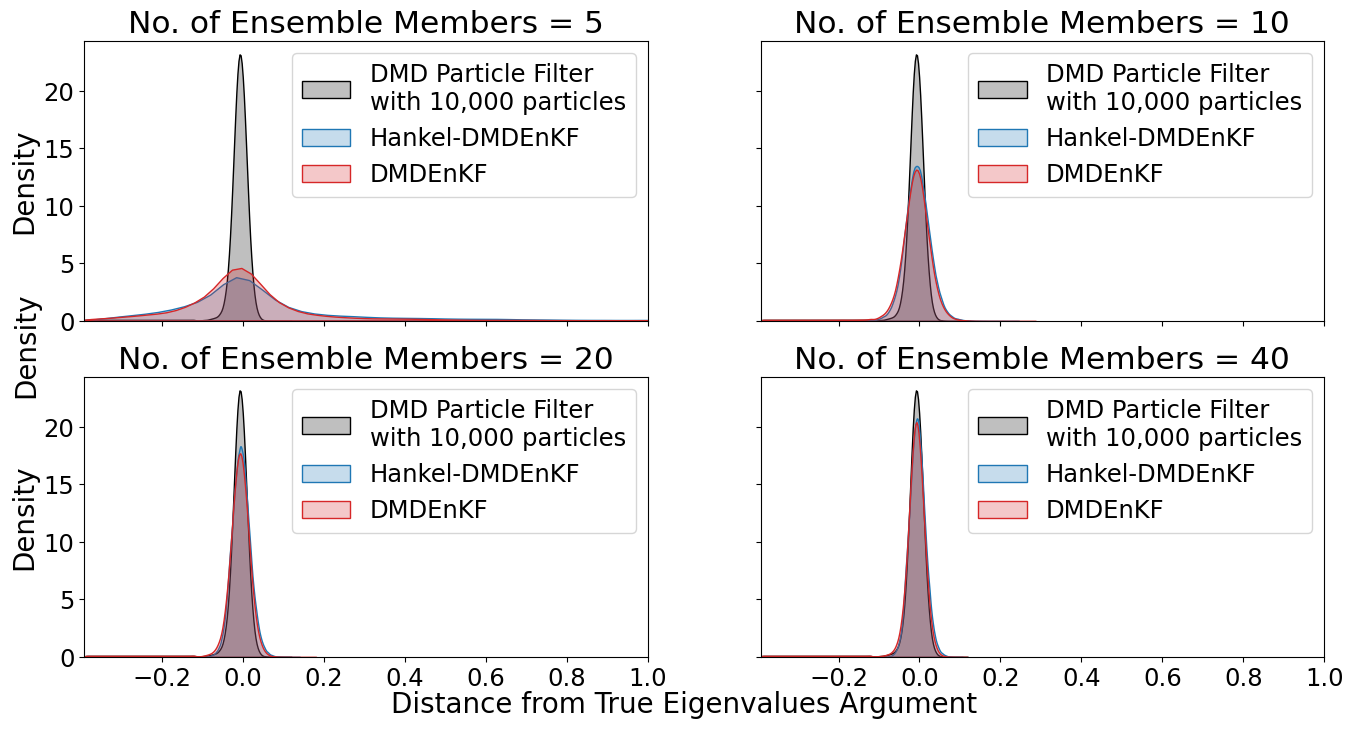

In [11]:
#Plot comparisons between the DMD particle filter and DMDEnKF's

#error distribution comparison

#set plot parameters
scaling = 1.25
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#setup axes
fig, ax = plt.subplots(2,2,sharex=True,sharey=True)
fig.text(0.5, 0.04, 'Distance from True Eigenvalues Argument', ha='center',size=MEDIUM_SIZE)
fig.text(0.08, 0.5, 'Density', va='center', rotation='vertical',size=MEDIUM_SIZE)
plt.xlim(-np.pi/8, 1)
#show plots for particle filter error distribtuion and ensemble error distribution for certain ensemble sizes
for i,ensemble_size in enumerate([5,10,20,40]):
    cax = ax[0 + math.floor(i/2)][i%2]
    sb.distplot(particle_filter_distributions,hist=False,kde=True,kde_kws = {'shade': True},label='DMD Particle Filter \nwith 10,000 particles',color='black',ax =cax)
    sb.distplot(ensemble_distributions[ensemble_size]['args'][4],hist=False,kde=True,kde_kws = {'shade': True},label='Hankel-DMDEnKF',color='tab:blue',ax =cax)
    sb.distplot(ensemble_distributions[ensemble_size]['args'][3],hist=False,kde=True,kde_kws = {'shade': True},label='DMDEnKF',color='tab:red',ax =cax)
    cax.set_title(f'No. of Ensemble Members = {ensemble_size}')
    cax.legend()
#plt.savefig('graphs/enkf_particle_N_comparison.png',bbox_inches='tight')

### Plot the Mean Squared Errors for each DMDEnKF's ensemble size against that of the relevant DMD Particle Filters (with or without complex conjugate cases removed)

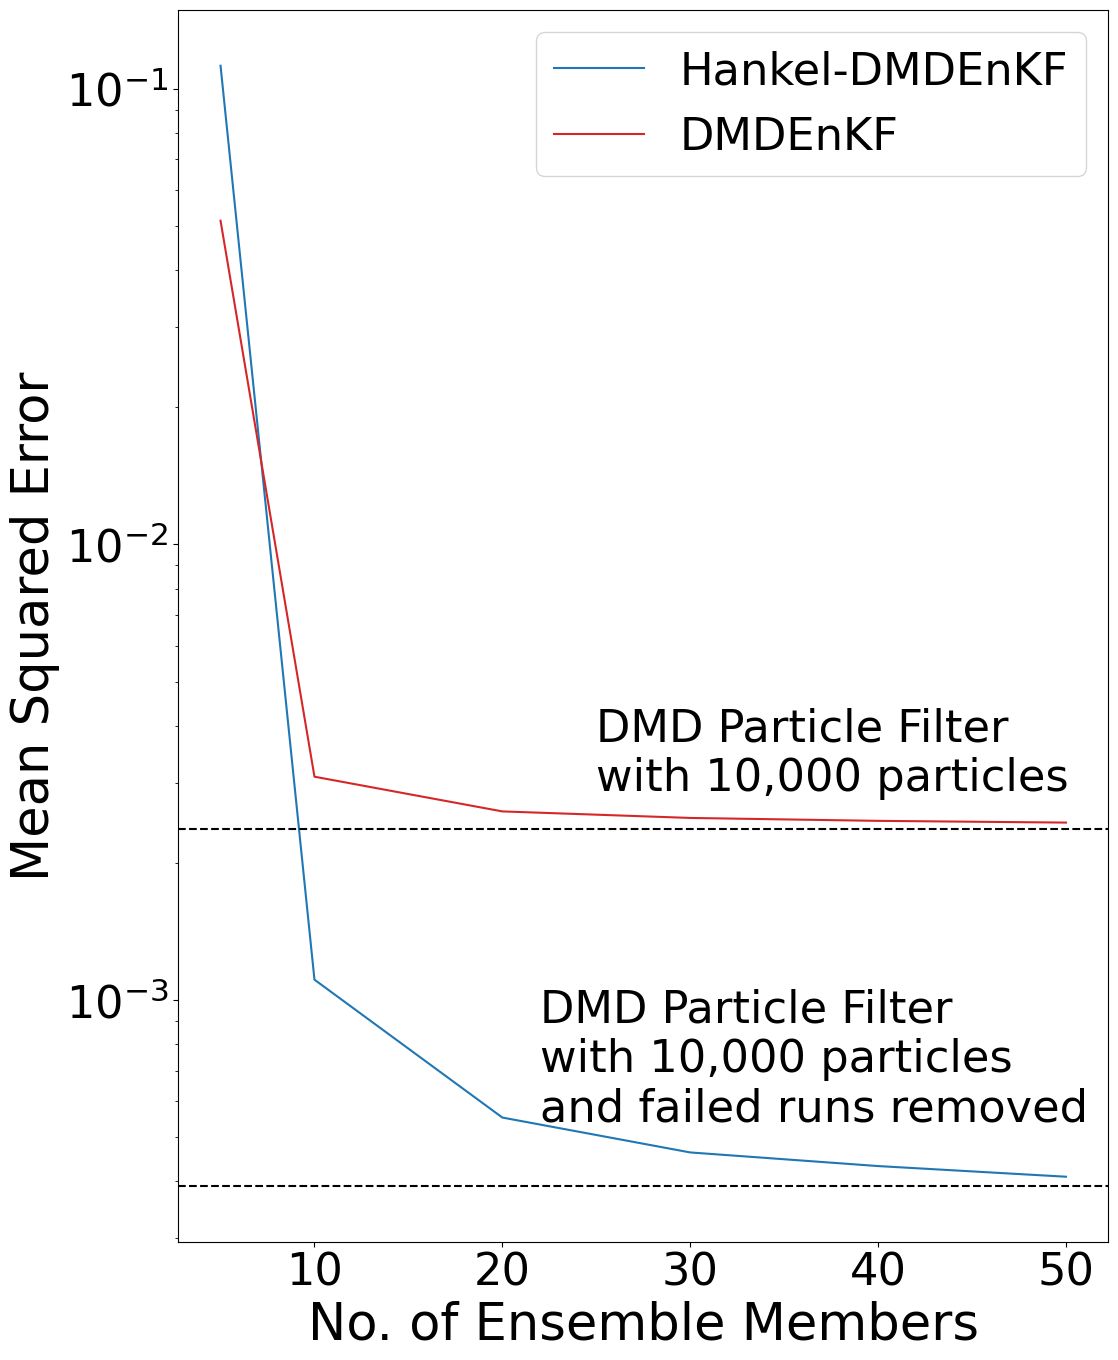

In [12]:
#Plot the average errors as ensemble size is increased

#set plot parameters
plt.rcParams["figure.figsize"] = (12,16) # (w, h)
scaling = 2.3
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

pf_runs = np.split(particle_filter_distributions,1000)
pfs_runs_to_remove = [all(pf_run == -thetas[-400:]) for pf_run in pf_runs]
pf_runs = [pf_run for pf_run,pf_remove in zip(pf_runs,pfs_runs_to_remove) if not pf_remove]
no_faulty_dmd_particle_filter_distributions = np.hstack(pf_runs)
no_fault_pf_mse = np.mean([i**2 for i in no_faulty_dmd_particle_filter_distributions])

#Mean Squared Error of eigenvalue's argument predicted using the DMDEnKF/HDMDEnKF with different numbers of ensemble members against that of a DMD particle filter with 10,000 particles plotted on a log scale.
pf_mse = np.mean([i**2 for i in particle_filter_distributions])
ensemble_mses = {k:np.mean([i**2 for i in v['args'][4]]) for k,v in ensemble_distributions.items()}
plt.plot(list(ensemble_mses.keys()),list(ensemble_mses.values()),label='Hankel-DMDEnKF',color='tab:blue')
ensemble_mses = {k:np.mean([i**2 for i in v['args'][3]]) for k,v in ensemble_distributions.items()}
plt.plot(list(ensemble_mses.keys()),list(ensemble_mses.values()),label='DMDEnKF',color='tab:red')
plt.axhline(pf_mse,color='black',linestyle='--')
plt.text(25,pf_mse+0.0005,'DMD Particle Filter \nwith 10,000 particles')
plt.axhline(no_fault_pf_mse,color='black',linestyle='--')
plt.text(22,no_fault_pf_mse+0.00015,'DMD Particle Filter \nwith 10,000 particles \nand failed runs removed')
plt.legend()
plt.ylabel('Mean Squared Error')
plt.xlabel('No. of Ensemble Members')
plt.yscale('log')
#plt.savefig(f'graphs/enkf_particle_N_comparison_MSE.png',bbox_inches='tight')

### View how DMDEnKF MSE relative to the DMD Particle Filter MSE decreases as number of ensemble members is increased

In [13]:
ensemble_mses = {k:np.mean([i**2 for i in v['args'][4]]) for k,v in ensemble_distributions.items()}
([i for i in ensemble_mses.values()]/no_fault_pf_mse)*100

array([28754.659702  ,   283.34468893,   141.14121372,   118.32118967,
         110.44693502,   104.65558844])

In [14]:
pf_mse

0.0023792234282121595